# ONNX graph, single or double floats

The notebook shows discrepencies obtained by using double floats instead of single float in two cases. The second one involves [GaussianProcessRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Simple case of a linear regression

A linear regression is simply a matrix multiplication followed by an addition: $Y=AX+B$. Let's train one with [scikit-learn](https://scikit-learn.org/stable/).

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
data = load_diabetes()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
clr = LinearRegression()
clr.fit(X_train, y_train)

LinearRegression()

In [3]:
clr.score(X_test, y_test)

0.48022823853163243

In [4]:
clr.coef_

array([  -3.66884712, -248.12455809,  503.47675603,  314.42722272,
       -937.79829646,  589.5139395 ,  166.9937767 ,  238.52080461,
        810.51985926,   83.1649252 ])

In [5]:
clr.intercept_

151.72119345267856

Let's predict with *scikit-learn* and *python*.

In [6]:
ypred = clr.predict(X_test)
ypred[:5]

array([ 65.19089869, 136.63206471, 197.78320816,  76.50979441,
       120.17048032])

In [7]:
py_pred = X_test @ clr.coef_ + clr.intercept_
py_pred[:5]

array([ 65.19089869, 136.63206471, 197.78320816,  76.50979441,
       120.17048032])

In [8]:
clr.coef_.dtype, clr.intercept_.dtype

(dtype('float64'), dtype('float64'))

## With ONNX

With *ONNX*, we would write this operation as follows... We still need to convert everything into single floats = float32.

In [9]:
%load_ext mlprodict

In [10]:
from skl2onnx.algebra.onnx_ops import OnnxMatMul, OnnxAdd
import numpy

onnx_fct = OnnxAdd(OnnxMatMul('X', clr.coef_.astype(numpy.float32), op_version=12),
                   numpy.array([clr.intercept_], dtype=numpy.float32),
                   output_names=['Y'], op_version=12)
onnx_model32 = onnx_fct.to_onnx({'X': X_test.astype(numpy.float32)})

# add -l 1 if nothing shows up
%onnxview onnx_model32

The next line uses a python runtime to compute the prediction.

In [11]:
from mlprodict.onnxrt import OnnxInference
oinf = OnnxInference(onnx_model32, inplace=False)
ort_pred = oinf.run({'X': X_test.astype(numpy.float32)})['Y']
ort_pred[:5]

array([ 65.190895, 136.63206 , 197.7832  ,  76.509796, 120.17048 ],
      dtype=float32)

And here is the same with [onnxruntime](https://github.com/microsoft/onnxruntime)...

In [12]:
oinf = OnnxInference(onnx_model32, runtime="onnxruntime1")
ort_pred = oinf.run({'X': X_test.astype(numpy.float32)})['Y']
ort_pred[:5]

array([ 65.190895, 136.63206 , 197.7832  ,  76.509796, 120.17048 ],
      dtype=float32)

## With double instead of single float

[ONNX](https://onnx.ai/) was originally designed for deep learning which usually uses floats but it does not mean cannot be used. Every number is converted into double floats.

In [13]:
onnx_fct = OnnxAdd(OnnxMatMul('X', clr.coef_.astype(numpy.float64), op_version=12),
                   numpy.array([clr.intercept_], dtype=numpy.float64),
                   output_names=['Y'], op_version=12)
onnx_model64 = onnx_fct.to_onnx({'X': X_test.astype(numpy.float64)})

And now the *python* runtime...

In [14]:
oinf = OnnxInference(onnx_model64)
ort_pred = oinf.run({'X': X_test})['Y']
ort_pred[:5]

array([ 65.19089869, 136.63206471, 197.78320816,  76.50979441,
       120.17048032])

And the *onnxruntime* version of it.

In [15]:
oinf = OnnxInference(onnx_model64, runtime="onnxruntime1")
ort_pred = oinf.run({'X': X_test.astype(numpy.float64)})['Y']
ort_pred[:5]

array([ 65.19089869, 136.63206471, 197.78320816,  76.50979441,
       120.17048032])

## And now the GaussianProcessRegressor

This shows a case

In [16]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct
gau = GaussianProcessRegressor(alpha=10, kernel=DotProduct())
gau.fit(X_train, y_train)

GaussianProcessRegressor(alpha=10, kernel=DotProduct(sigma_0=1))

In [17]:
from mlprodict.onnx_conv import to_onnx
onnxgau32 = to_onnx(gau, X_train.astype(numpy.float32))
oinf32 = OnnxInference(onnxgau32, runtime="python", inplace=False)
ort_pred32 = oinf32.run({'X': X_test.astype(numpy.float32)})['GPmean']
numpy.squeeze(ort_pred32)[:25]

array([136.    , 146.75  , 156.875 , 137.625 , 143.6875, 157.25  ,
       137.625 , 155.4375, 157.125 , 176.1875, 154.    , 144.6875,
       152.875 , 163.0625, 134.5   , 169.25  , 143.4375, 156.    ,
       147.9375, 147.5625, 143.5625, 139.5   , 167.3125, 162.8125,
       157.5   ], dtype=float32)

In [18]:
onnxgau64 = to_onnx(gau, X_train.astype(numpy.float64))
oinf64 = OnnxInference(onnxgau64, runtime="python", inplace=False)
ort_pred64 = oinf64.run({'X': X_test.astype(numpy.float64)})['GPmean']
numpy.squeeze(ort_pred64)[:25]

array([136.29042094, 147.37000865, 157.17181659, 137.37942361,
       143.75809938, 157.26946743, 138.0470418 , 155.13779478,
       157.13725317, 176.25699851, 154.58148006, 144.76382797,
       152.92400576, 162.55328615, 135.01672829, 169.57752091,
       144.15882691, 155.9305585 , 147.74172845, 147.95694225,
       143.58627788, 139.44744308, 167.34231253, 162.89442931,
       157.77991459])

The differences between the predictions for single floats and double floats...

In [19]:
numpy.sort(numpy.sort(numpy.squeeze(ort_pred32 - ort_pred64)))[-5:]

array([0.35428989, 0.37583714, 0.39413358, 0.46870174, 0.50921385])

Who's right or wrong... The differences between the predictions with the original model...

In [20]:
pred = gau.predict(X_test.astype(numpy.float64))

In [21]:
numpy.sort(numpy.sort(numpy.squeeze(ort_pred32 - pred)))[-5:]

array([[-2.53819985e+01, -2.50722714e+01, -2.14450449e+01,
        -2.00524647e+01, -1.95723838e+01, -1.87025209e+01,
        -1.64673125e+01, -1.59125835e+01, -1.55697413e+01,
        -1.55154512e+01, -1.50184911e+01, -1.41483318e+01,
        -1.40623681e+01, -1.30606141e+01, -1.30289437e+01,
        -1.28485784e+01, -1.26562983e+01, -1.20194293e+01,
        -1.16782862e+01, -1.11241629e+01, -1.03175536e+01,
        -9.62974691e+00, -9.62801189e+00, -9.48419875e+00,
        -9.35995816e+00, -9.17521553e+00, -8.87705881e+00,
        -8.70495702e+00, -7.75760088e+00, -7.16953019e+00,
        -7.12544216e+00, -6.90491459e+00, -6.63742534e+00,
        -6.62542751e+00, -6.56554431e+00, -6.49066331e+00,
        -6.39446743e+00, -6.35915325e+00, -6.32373986e+00,
        -6.29681659e+00, -6.26225317e+00, -6.21640097e+00,
        -5.27455577e+00, -5.05555850e+00, -4.26279478e+00,
        -3.76824125e+00, -3.70648006e+00, -3.56134387e+00,
        -3.53965309e+00, -3.40999971e+00, -3.24941609e+0

In [22]:
numpy.sort(numpy.sort(numpy.squeeze(ort_pred64 - pred)))[-5:]

array([[-25.3059382 , -24.9962111 , -21.36898463, -19.9764044 ,
        -19.49632349, -18.6264606 , -16.39125222, -15.83652317,
        -15.49368102, -15.43939086, -14.94243076, -14.07227152,
        -13.98630775, -12.98455375, -12.95288335, -12.77251811,
        -12.58023795, -11.943369  , -11.60222584, -11.04810255,
        -10.24149325,  -9.5536866 ,  -9.55195157,  -9.40813844,
         -9.28389785,  -9.09915522,  -8.80099849,  -8.62889671,
         -7.68154057,  -7.09346988,  -7.04938185,  -6.82885428,
         -6.56136503,  -6.54936719,  -6.489484  ,  -6.414603  ,
         -6.31840711,  -6.28309294,  -6.24767955,  -6.22075628,
         -6.18619286,  -6.14034066,  -5.19849546,  -4.97949819,
         -4.18673447,  -3.69218093,  -3.63041975,  -3.48528356,
         -3.46359277,  -3.33393939,  -3.17335578,  -2.44175195,
         -2.15449039,  -2.09943248,  -1.97294545,  -1.4925011 ,
         -0.34968678,   0.        ,   0.51246638,   1.74239929,
          2.31189269,   2.41700919,   2.

Double predictions clearly wins.

In [23]:
# add -l 1 if nothing shows up
%onnxview onnxgau64

## Saves...

Let's keep track of it.

In [24]:
with open("gpr_dot_product_boston_32.onnx", "wb") as f:
    f.write(onnxgau32.SerializePartialToString())
from IPython.display import FileLink
FileLink('gpr_dot_product_boston_32.onnx')

C:\xavierdupre\__home_\GitHub\mlprodict\_doc\notebooks\gpr_dot_product_boston_32.onnx

In [25]:
with open("gpr_dot_product_boston_64.onnx", "wb") as f:
    f.write(onnxgau64.SerializePartialToString())
FileLink('gpr_dot_product_boston_64.onnx')

C:\xavierdupre\__home_\GitHub\mlprodict\_doc\notebooks\gpr_dot_product_boston_64.onnx

## Side by side

We may wonder where the discrepencies start. But for that, we need to do a side by side.

In [26]:
from mlprodict.onnxrt.validate.side_by_side import side_by_side_by_values
sbs = side_by_side_by_values([(oinf32, {'X': X_test.astype(numpy.float32)}),
                              (oinf64, {'X': X_test.astype(numpy.float64)})])

from pandas import DataFrame
df = DataFrame(sbs)
# dfd = df.drop(['value[0]', 'value[1]', 'value[2]'], axis=1).copy()
df

,metric,step,v[0],v[1],cmp,name,order[0],value[0],shape[0],order[1],value[1],shape[1]
0,nb_results,-1,11,1.100000e+01,OK,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,abs-diff,0,0,7.184343e-09,OK,X,0.0,"[[-0.0018820165, -0.044641636, -0.05147406, -0...","(111, 10)",0.0,"[[-0.0018820165277906047, -0.04464163650698914...","(111, 10)"
2,abs-diff,1,0,7.241096e-01,ERROR->=0.7,GPmean,5.0,"[[136.0], [146.75], [156.875], [137.625], [143...","(111, 1)",5.0,"[[136.2904209381668], [147.37000865291338], [1...","(111, 1)"
3,abs-diff,2,0,7.150779e-09,OK,kgpd_MatMulcst,-1.0,"[[-0.103593096, -0.009147094, 0.016280675, -0....","(10, 331)",-1.0,"[[-0.10359309315633439, -0.009147093429829445,...","(10, 331)"
4,abs-diff,3,0,2.693608e-04,e<0.001,kgpd_Addcst,-1.0,[23321.936],"(1,)",-1.0,[23321.93527751423],"(1,)"
5,abs-diff,4,0,9.174340e-07,OK,gpr_MatMulcst,-1.0,"[-6.7274747, 3.3635502, -4.675215, -7.969895, ...","(331,)",-1.0,"[-6.7274746537081995, 3.363550107698292, -4.67...","(331,)"
6,abs-diff,5,0,0.000000e+00,OK,gpr_Addcst,-1.0,[[0.0]],"(1, 1)",-1.0,[[0.0]],"(1, 1)"
7,abs-diff,6,0,0.000000e+00,OK,Re_Reshapecst,-1.0,"[-1, 1]","(2,)",-1.0,"[-1, 1]","(2,)"
8,abs-diff,7,0,7.989149e-09,OK,kgpd_Y0,1.0,"[[0.013952837, 0.004027498, 0.0033139654, 0.01...","(111, 331)",1.0,"[[0.013952837286119372, 0.0040274979445440616,...","(111, 331)"
9,abs-diff,8,0,1.245899e-03,e<0.01,kgpd_C0,2.0,"[[23321.95, 23321.94, 23321.94, 23321.953, 233...","(111, 331)",2.0,"[[23321.949230351514, 23321.939305012173, 2332...","(111, 331)"


The differences really starts for output ``'O0'`` after the matrix multiplication. This matrix melts different number with very different order of magnitudes and that alone explains the discrepencies with doubles and floats on that particular model.

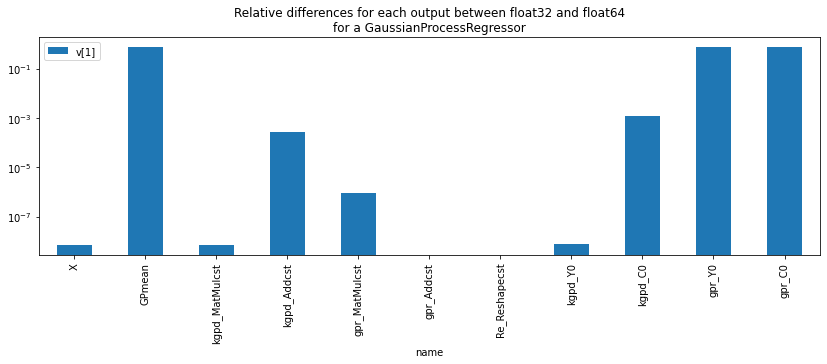

In [27]:
%matplotlib inline
ax = df[['name', 'v[1]']].iloc[1:].set_index('name').plot(kind='bar', figsize=(14,4), logy=True)
ax.set_title("Relative differences for each output between float32 and "
             "float64\nfor a GaussianProcessRegressor");

Before going further, let's check how sensitive the trained model is about converting double into floats.

In [28]:
pg1 = gau.predict(X_test)
pg2 = gau.predict(X_test.astype(numpy.float32).astype(numpy.float64))
numpy.sort(numpy.sort(numpy.squeeze(pg1 - pg2)))[-5:]

array([2.71829776e-07, 2.75555067e-07, 2.98605300e-07, 3.28873284e-07,
       3.92203219e-07])

Having float or double inputs should not matter. We confirm that with the model converted into ONNX.

In [29]:
p1 = oinf64.run({'X': X_test})['GPmean']
p2 = oinf64.run({'X': X_test.astype(numpy.float32).astype(numpy.float64)})['GPmean']
numpy.sort(numpy.sort(numpy.squeeze(p1 - p2)))[-5:]

array([2.71829776e-07, 2.75555067e-07, 2.98605300e-07, 3.28873284e-07,
       3.92203219e-07])

Last verification.

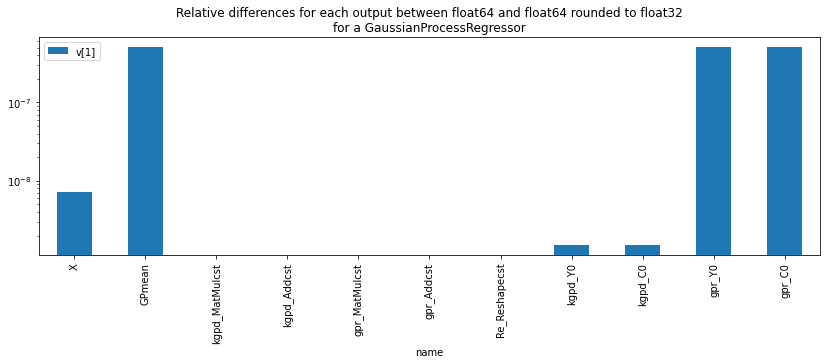

In [30]:
sbs = side_by_side_by_values([(oinf64, {'X': X_test.astype(numpy.float32).astype(numpy.float64)}),
                              (oinf64, {'X': X_test.astype(numpy.float64)})])
df = DataFrame(sbs)
ax = df[['name', 'v[1]']].iloc[1:].set_index('name').plot(kind='bar', figsize=(14,4), logy=True)
ax.set_title("Relative differences for each output between float64 and float64 rounded to float32"
             "\nfor a GaussianProcessRegressor");